# Fine-tuning Qwen2.5-VL-7B-Instruct with MLX-VLM (Native MLX)

This notebook uses **MLX-VLM** for native MLX fine-tuning on Apple Silicon.

**Requirements:**
- macOS with Apple Silicon (M1/M2/M3/M4)
- Python 3.9+
- 32GB+ RAM recommended

**MLX-VLM Repository:** https://github.com/Blaizzy/mlx-vlm

## 1. Environment Setup

In [2]:
# Install MLX-VLM and dependencies
!pip install -q -U pip
!pip install -q mlx-vlm
!pip install -q pillow datasets scikit-learn tqdm

print("✅ Installation complete!")

✅ Installation complete!


In [3]:
# Import libraries
import os
import json
import re
from pathlib import Path
from PIL import Image, ImageFile
import numpy as np

# MLX imports
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

# MLX-VLM imports
from mlx_vlm import load, generate
from mlx_vlm.utils import load_config

print(f"MLX version: {mx.__version__}")
print(f"Device: Apple Silicon")

# Set random seed
np.random.seed(42)
mx.random.seed(42)

MLX version: 0.29.3
Device: Apple Silicon


## 2. Data Configuration

In [4]:
# Data paths - Update these to match your local paths
DATA_DIR = "/Users/berta/Documents/Projects/mathvista"
JSONL_PATH = f"{DATA_DIR}/mathvista_testmini.jsonl"
IMAGES_DIR = f"{DATA_DIR}/mathvista_testmini_images"

# Verify paths exist
assert os.path.exists(JSONL_PATH), f"JSONL file not found: {JSONL_PATH}"
assert os.path.exists(IMAGES_DIR), f"Images directory not found: {IMAGES_DIR}"

print(f"✅ Data directory: {DATA_DIR}")
print(f"✅ JSONL file: {JSONL_PATH}")
print(f"✅ Images directory: {IMAGES_DIR}")

✅ Data directory: /Users/berta/Documents/Projects/mathvista
✅ JSONL file: /Users/berta/Documents/Projects/mathvista/mathvista_testmini.jsonl
✅ Images directory: /Users/berta/Documents/Projects/mathvista/mathvista_testmini_images


## 3. Load and Prepare Data

In [5]:
# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

def clean_image_tokens(text):
    """Remove any existing image tokens from text."""
    patterns = [
        r'<\|image_pad\|>',
        r'<\|vision_start\|>',
        r'<\|vision_end\|>',
        r'<image>',
        r'</image>',
        r'\[IMG\d*\]',
    ]
    cleaned = text
    for pattern in patterns:
        cleaned = re.sub(pattern, '', cleaned)
    return cleaned.strip()

def load_mathverse_data(jsonl_path, images_dir, max_samples=None):
    """
    Load MathVerse dataset in MLX-VLM format.
    
    MLX-VLM expects data in format:
    [
        {
            "image": "path/to/image.jpg",
            "prompt": "Question text",
            "answer": "Answer text"
        },
        ...
    ]
    """
    data = []
    errors = 0
    image_errors = 0
    
    with open(jsonl_path, 'r', encoding='utf-8') as f:
        for idx, line in enumerate(f):
            if max_samples and len(data) >= max_samples:
                break
            
            if not line.strip():
                continue
                
            try:
                item = json.loads(line)
            except json.JSONDecodeError as e:
                print(f"Warning: Skipping line {idx+1} due to JSON error")
                errors += 1
                continue
            
            # Construct image path
            image_path = os.path.join(images_dir, item['image_path'])
            
            if not os.path.exists(image_path):
                continue
            
            # Get question and answer
            question = clean_image_tokens(item.get('query', ''))
            answer = item.get('answer', '')
            
            if not question or not answer:
                continue
            
            # Verify image can be loaded
            try:
                img = Image.open(image_path)
                _ = img.size
                img.close()
            except (OSError, IOError):
                image_errors += 1
                continue
            
            # MLX-VLM format
            data.append({
                "image": image_path,
                "prompt": question,
                "answer": answer
            })
    
    print(f"✅ Loaded {len(data)} samples")
    if errors > 0:
        print(f"⚠️ Skipped {errors} lines due to JSON errors")
    if image_errors > 0:
        print(f"⚠️ Skipped {image_errors} corrupted images")
    return data

# Load data
raw_data = load_mathverse_data(
    JSONL_PATH, 
    IMAGES_DIR,
    max_samples=None  # Set to 100 for quick testing
)

# Display sample
if raw_data:
    print("\nSample data:")
    print(f"Image: {raw_data[0]['image']}")
    print(f"Prompt: {raw_data[0]['prompt'][:200]}...")
    print(f"Answer: {raw_data[0]['answer']}")

✅ Loaded 821 samples

Sample data:
Image: /Users/berta/Documents/Projects/mathvista/mathvista_testmini_images/question_0000.png
Prompt: Hint: Please answer the question requiring a floating-point number with one decimal place and provide the final value, e.g., 1.2, 1.3, 1.4, at the end.
Question: When a spring does work on an object, ...
Answer: 1.2


In [6]:
# Split data into train and validation sets
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(
    raw_data, 
    test_size=0.1,
    random_state=42
)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")

# Save to JSONL files for MLX-VLM
with open('train.jsonl', 'w') as f:
    for item in train_data:
        f.write(json.dumps(item) + '\n')

with open('val.jsonl', 'w') as f:
    for item in val_data:
        f.write(json.dumps(item) + '\n')

print("\n✅ Saved train.jsonl and val.jsonl")

Training samples: 738
Validation samples: 83

✅ Saved train.jsonl and val.jsonl


## 4. Load Model with MLX-VLM

In [7]:
# Model configuration
MODEL_NAME = "Qwen/Qwen2.5-VL-7B-Instruct"

# Load model and processor
print(f"Loading model: {MODEL_NAME}")
print("This may take a few minutes on first run...")

model, processor = load(MODEL_NAME)

print("✅ Model loaded successfully!")
print(f"Model type: {type(model)}")

Loading model: Qwen/Qwen2.5-VL-7B-Instruct
This may take a few minutes on first run...


Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


✅ Model loaded successfully!
Model type: <class 'mlx_vlm.models.qwen2_5_vl.qwen2_5_vl.Model'>


## 5. Test Base Model (Before Fine-tuning)

Testing base model...
Question: Hint: Please answer the question requiring a floating-point number with two decimal places and provide the final value, e.g., 1.23, 1.34, 1.45, at the end.
Question: What is the different between the ...
Expected: 10.53

Base Model Response: GenerationResult(text=" The highest unemployment rate is 12.5% and the lowest is 7.8%. To find the difference between the highest and lowest unemployment rates, subtract the lowest rate from the highest rate.\nTo find the difference between the highest and lowest unemployment rates, we need to subtract the lowest rate from the highest rate. The highest unemployment rate is 12.5% and the lowest is 7.8%. Let's perform the subtraction:\n\n\\[ 12.5\\% - 7.8\\% = 4.7\\% \\]\n\nSo, the difference between the highest and lowest unemployment rates is ", token=220, logprobs=array([-18, -20.5, -22.5, ..., -26.75, -26.75, -26.75], dtype=bfloat16), prompt_tokens=61, generation_tokens=128, total_tokens=189, prompt_tps=37.51259421

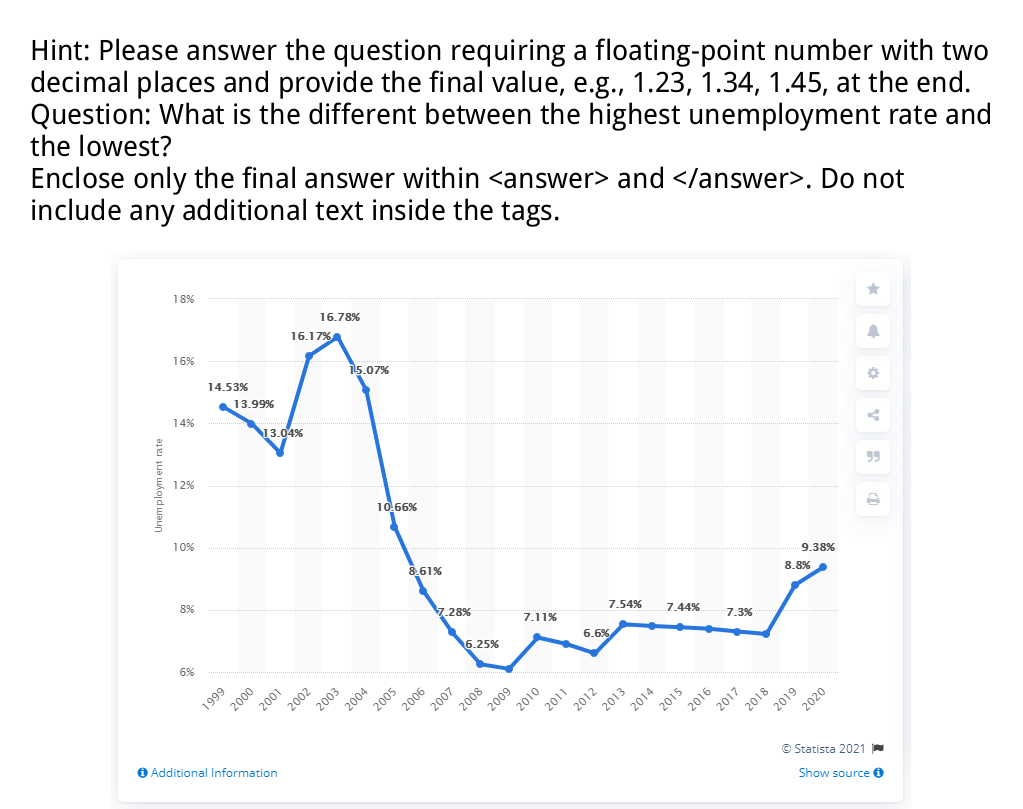

In [8]:
# Test on a sample
test_sample = val_data[0]
test_image = Image.open(test_sample['image'])

print("Testing base model...")
print(f"Question: {test_sample['prompt'][:200]}...")
print(f"Expected: {test_sample['answer']}")

# Generate response
response = generate(
    model,
    processor,
    test_sample['prompt'],
    test_image,
    max_tokens=128,
    temp=0.0
)

print(f"\nBase Model Response: {response}")
print("\nImage:")
display(test_image)


## 6. Fine-tune with LoRA using MLX-VLM CLI

MLX-VLM provides a command-line interface for fine-tuning. We'll use it from the notebook.

In [9]:
# Training configuration
BATCH_SIZE = 1
ITERS = 300  # Number of training iterations
LEARNING_RATE = 1e-5
LORA_RANK = 16
ADAPTER_FILE = "adapters.safetensors"
OUTPUT_DIR = "./qwen2_5_vl_finetuned_mlx"

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Training configuration:")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Iterations: {ITERS}")
print(f"  - Learning rate: {LEARNING_RATE}")
print(f"  - LoRA rank: {LORA_RANK}")
print(f"  - Output: {OUTPUT_DIR}")

Training configuration:
  - Batch size: 1
  - Iterations: 300
  - Learning rate: 1e-05
  - LoRA rank: 16
  - Output: ./qwen2_5_vl_finetuned_mlx


In [ ]:
# Train using MLX-VLM Python APIfrom mlx_vlm.trainer.trainer import Trainer, TrainingArgsfrom mlx_vlm.trainer.utils import build_datasetimport mlx.optimizers as optimimport mlx.nn as nnprint("Preparing training...")# Load training datatrain_dataset = build_dataset(    data_path="train.jsonl",    model_name=MODEL_NAME,    processor=processor)val_dataset = build_dataset(    data_path="val.jsonl",    model_name=MODEL_NAME,    processor=processor)print(f"Training samples: {len(train_dataset)}")print(f"Validation samples: {len(val_dataset)}")# Training argumentstraining_args = TrainingArgs(    batch_size=BATCH_SIZE,    iters=ITERS,    steps_per_report=10,    steps_per_eval=50,    steps_per_save=100,    adapter_file=ADAPTER_FILE,    max_seq_length=2048)# Create optimizeroptimizer = optim.Adam(learning_rate=LEARNING_RATE)# Create trainertrainer = Trainer(    model=model,    optimizer=optimizer,    train_on_completions=True)print("\nStarting training...")print(f"  - Batch size: {training_args.batch_size}")print(f"  - Iterations: {training_args.iters}")print(f"  - Learning rate: {LEARNING_RATE}")print(f"  - LoRA rank: {LORA_RANK}")print("")# Traintrainer.train(    train_dataset=train_dataset,    val_dataset=val_dataset,    training_args=training_args)print("\n✅ Fine-tuning completed!")print(f"Adapters saved to: {ADAPTER_FILE}")

## 7. Test Fine-tuned Model

In [ ]:
# Load model with adapters
print("Loading fine-tuned model with adapters...")

# Reload model with adapters
model, processor = load(
    MODEL_NAME,
    adapter_path=ADAPTER_FILE
)

print("✅ Fine-tuned model loaded!")

In [ ]:
# Test on same sample
test_sample = val_data[0]
test_image = Image.open(test_sample['image'])

print("Testing fine-tuned model...")
print(f"Question: {test_sample['prompt'][:200]}...")
print(f"Expected: {test_sample['answer']}")

# Generate response
response = generate(
    model,
    processor,
    test_sample['prompt'],
    test_image,
    max_tokens=128,
    temp=0.0
)

print(f"\nFine-tuned Model Response: {response}")
print("\nImage:")
display(test_image)


## 8. Evaluation on Validation Set

In [ ]:
# Evaluate fine-tuned model
from tqdm.auto import tqdm

def extract_answer(text, question_type='multi-choice'):
    """Extract answer from model output."""
    if question_type == 'multi-choice':
        matches = re.findall(r'\b([A-D])\b', text.upper())
        if matches:
            return matches[-1]
        return None
    else:
        return text.strip()

def evaluate_model(model, processor, test_data, max_samples=None):
    """Evaluate model on test dataset."""
    results = []
    correct = 0
    total = 0

    samples_to_eval = test_data[:max_samples] if max_samples else test_data

    for idx, sample in enumerate(tqdm(samples_to_eval, desc="Evaluating")):
        try:
            image = Image.open(sample['image'])
            question = sample['prompt']
            expected = sample['answer']

            # Determine question type
            question_type = 'multi-choice' if 'Choices:' in question else 'free-form'

            # Generate response
            response = generate(
                model,
                processor,
                question,
                image,
                max_tokens=128,
                temp=0.0
            )

            # Extract answer
            predicted = extract_answer(response, question_type)

            # Check correctness
            is_correct = False
            if question_type == 'multi-choice':
                expected_letter = extract_answer(expected, 'multi-choice')
                if expected_letter is None:
                    expected_letter = expected.strip().upper()
                is_correct = (predicted == expected_letter)
            else:
                is_correct = (expected.lower() in response.lower())

            if is_correct:
                correct += 1
            total += 1

            results.append({
                'index': idx,
                'expected': expected,
                'predicted': predicted if predicted else response[:100],
                'correct': is_correct
            })

        except Exception as e:
            print(f"Error on sample {idx}: {e}")
            continue

    accuracy = (correct / total * 100) if total > 0 else 0
    return results, accuracy

# Run evaluation
print("Evaluating fine-tuned model on validation set...")
results, accuracy = evaluate_model(
    model,
    processor,
    val_data,
    max_samples=None  # Set to 10 for quick test
)

print(f"\n" + "=" * 80)
print(f"EVALUATION RESULTS")
print("=" * 80)
print(f"Total Samples: {len(results)}")
print(f"Correct: {sum(1 for r in results if r['correct'])}")
print(f"Accuracy: {accuracy:.2f}%")
print("=" * 80)

# Save results
with open('evaluation_results_mlx.json', 'w') as f:
    json.dump({
        'accuracy': accuracy,
        'results': results
    }, f, indent=2)

print("\n✅ Results saved to: evaluation_results_mlx.json")


## 9. Save and Export Model

In [ ]:
# The adapters are already saved in adapters.safetensors
# To use the model later:

print("Model artifacts:")
print(f"  - Adapters: {ADAPTER_FILE}")
print(f"  - Training data: train.jsonl")
print(f"  - Validation data: val.jsonl")
print(f"\nTo load later:")
print(f"  model, processor = load('{MODEL_NAME}', adapter_path='{ADAPTER_FILE}')")

## 10. Fuse Adapters (Optional)

You can merge the LoRA adapters into the base model for easier deployment.

In [ ]:
# Note: MLX-VLM 0.3.5 does not have a built-in fuse command# The adapters are already saved and can be used directlyprint("Model artifacts:")print(f"  - Base model: {MODEL_NAME}")print(f"  - LoRA adapters: {ADAPTER_FILE}")print(f"  - Training data: train.jsonl")print(f"  - Validation data: val.jsonl")print("")print("To use the fine-tuned model later:")print(f"  from mlx_vlm import load")print(f"  model, processor = load('{MODEL_NAME}', adapter_path='{ADAPTER_FILE}')")print("")print("Note: The adapters are lightweight (~50-200MB) and will be")print("automatically loaded on top of the base model.")

## Notes

### Performance on Apple Silicon

**M4:**
- Training speed: ~100-200 tokens/sec
- Memory usage: ~15-20GB
- Recommended: batch_size=1, iters=300

**M4 Pro/Max:**
- Training speed: ~200-400 tokens/sec
- Memory usage: ~20-30GB
- Can use larger batch sizes

### Tips

- **Reduce memory**: Lower `lora_rank` to 8 or use smaller `max_seq_length`
- **Speed up**: Use smaller `max_samples` for testing
- **Resume training**: Add `--resume-adapter-file` flag
- **Quantization**: Use 4-bit quantized model for lower memory usage

### Resources

- MLX-VLM GitHub: https://github.com/Blaizzy/mlx-vlm
- MLX Documentation: https://ml-explore.github.io/mlx/
- Qwen2.5-VL: https://huggingface.co/Qwen/Qwen2.5-VL-7B-Instruct